# Audio tutorial

This tutorial walks through loading in individual audio records as well as the entire dataset.

In [1]:
import matplotlib.pyplot as plt
import IPython.display as Ipd
import pandas as pd
import torch
from pathlib import Path
import numpy as np

# from b2aiprep.process import SpeechToText
from senselab.audio.tasks.speech_to_text.api import transcribe_audios

# from b2aiprep.process import specgram
from senselab.audio.data_structures.audio import Audio
from senselab.utils.data_structures.model import HFModel
from senselab.audio.tasks.features_extraction.torchaudio import extract_spectrogram_from_audios
from senselab.audio.tasks.preprocessing.preprocessing import resample_audios

from b2aiprep.dataset import VBAIDataset

/Users/isaacbevers/sensein/b2ai-wrapper/.venv/lib/python3.10/site-packages/pydantic/_internal/_fields.py:160: UserWarning: Field "model_info" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(


We have reformatted the data into a [BIDS](https://bids-standard.github.io/bids-starter-kit/folders_and_files/folders.html)-like format. The data is stored in a directory with the following structure:

```
data/
    sub-01/
        ses-01/
            beh/
                sub-01_ses-01_questionnaire.json
            audio/
                sub-01_ses-01_recording.wav
    sub-02/
        ses-01/
            beh/
                sub-02_ses-01_questionnaire.json
            audio/
                sub-02_ses-01_recording.wav
    ...
```

i.e. the data reflects a subject-session-datatype hierarchy. The `beh` subfolder, for behavioural data, was chosen to store questionnaire data as it is the closest approximation to the data collected. The `audio` subfolder contains audio data.

We have provided utilities which load in data from the BIDS-like dataset structure. The only input needed is the folder path which stores the data.

In [2]:
dataset = VBAIDataset('../output')  # Your path to the bids-like-dataset here

## Finding data

The dataset functions are convenient, but they require some prior knowledge: we needed to know that `sessionschema` was the name for the questionnaire with session information. We also needed to know that `demographics` was the name for the questionnaire where general demographics were collected. For convenience, the dataset object has another method which tells you all of the questionnaire names available. It accomplishes this by iterating through every file of the BIDS dataset. Note that this can be an expensive operation! Luckily, if there are less than 10,000 files, it goes pretty fast. Let's try it out.

In [3]:
participant_df = dataset.load_and_pivot_questionnaire('participant')
participant_df.head()

linkId,record_id,selected_language,enrollment_institution,age,eligible_studies___1,eligible_studies___2,eligible_studies___3,eligible_studies___4,eligible_studies___5,is_control_participant,...,diagnosis_als_treatment_and_management_yes_medications___tofersen,diagnosis_als_treatment_and_management_yes_medications___symptomatic_treatment,diagnosis_als_treatment_and_management_yes_medications___other,diagnosis_als_treatment_and_management_yes_supportive_care___physical_therapy,diagnosis_als_treatment_and_management_yes_supportive_care___occupational_therapy,diagnosis_als_treatment_and_management_yes_supportive_care___speech_therapy,diagnosis_als_treatment_and_management_yes_supportive_care___respiratory_support,diagnosis_als_treatment_and_management_yes_supportive_care___nutrition_support,diagnosis_als_treatment_and_management_yes_supportive_care___psychotherapy,diagnosis_als_treatment_and_management_yes_supportive_care___other
0,1f9475bb-f13b-4f68-969b-28f20455b3e7,English,Mt. Sinai,79.0,False,True,False,False,False,No,...,False,False,False,False,False,False,False,False,False,False
1,7f10bd3f-cbf9-4875-9716-308af292d058,English,USF,71.0,False,True,False,True,False,No,...,False,False,False,False,False,False,False,False,False,False
2,49d831ec-f348-43de-8202-15f659196b02,English,VUMC,36.0,True,True,True,True,False,Yes,...,False,False,False,False,False,False,False,False,False,False
3,4464b02f-bee1-4b72-84e5-55700c8bbc67,English,Mt. Sinai,84.0,False,True,False,False,False,No,...,False,False,False,False,False,False,False,False,False,False
4,b1fe4758-940f-4ffc-8ad2-2c1054f14e95,English,MIT,54.0,False,False,True,False,False,No,...,False,False,False,False,False,False,False,False,False,False


## Acoustic tasks

Let's look at the acoustic tasks now. Acoustic task files are organized in the following way:

```
data/
    sub-01/
        ses-01/
            beh/
                sub-01_ses-01_task-<TaskName>_acoustictaskschema.json
                sub-01_ses-01_task-<TaskName>_rec-<TaskName>-1_recordingschema.json
                ...
```

where `TaskName` is the name of the acoustic task, including:

* `Audio-Check`
* `Cinderalla-Story`
* `Rainbow-Passage`

etc. The audio tasks are listed currently in b2aiprep/prepare.py:_AUDIO_TASKS.

In [4]:
acoustic_task_df = dataset.load_and_pivot_questionnaire('acoustictaskschema')
acoustic_task_df.head()

linkId,record_id,acoustic_task_id,acoustic_task_session_id,acoustic_task_name,acoustic_task_cohort,acoustic_task_status,acoustic_task_duration
0,1f9475bb-f13b-4f68-969b-28f20455b3e7,8BFBF8CF-A348-446F-8341-511426567A3D,CB8A74EE-0C8C-4B15-B322-D93A79ADB40A,Picture description,generic,Completed,75.0
1,1f9475bb-f13b-4f68-969b-28f20455b3e7,E6DA23B6-2DCD-4CA4-8F9A-D6BC084584AC,CB8A74EE-0C8C-4B15-B322-D93A79ADB40A,Respiration and cough,generic,Completed,166.0
2,1f9475bb-f13b-4f68-969b-28f20455b3e7,69141449-2A61-4C47-A3A3-391B454FC673,CB8A74EE-0C8C-4B15-B322-D93A79ADB40A,Audio Check,generic,Completed,58.0
3,1f9475bb-f13b-4f68-969b-28f20455b3e7,EC2F200F-F26B-490D-ADB2-DBC10D7B980F,CB8A74EE-0C8C-4B15-B322-D93A79ADB40A,Loudness,generic,Completed,17.0
4,1f9475bb-f13b-4f68-969b-28f20455b3e7,1138695B-A755-4070-BC71-480160D076E4,CB8A74EE-0C8C-4B15-B322-D93A79ADB40A,Story recall,generic,Completed,210.0


Each row in the above corresponds to a different acoustic task: an audio check, prolonged vowels, etc. The `value_counts()` method for pandas DataFrames lets us count all the unique values for a column.

In [5]:
acoustic_task_df['acoustic_task_name'].value_counts()

acoustic_task_name
Audio Check                197
Maximum phonation time     175
Glides                     175
Loudness                   174
Diadochokinesis            174
Prolonged vowel            174
Respiration and cough      174
Rainbow Passage            174
Picture description        171
Story recall               171
Free speech                114
Caterpillar Passage         72
Breath Sounds               72
Voluntary Cough             72
Cape V sentences            72
Free Speech                 62
Animal fluency              43
Open response questions     42
Cinderella Story            18
Productive Vocabulary       17
Word-color Stroop           17
Random Item Generation      17
Name: count, dtype: int64

The hierarchy for a single session is the following:

```
subject
└── session
    └── acoustic_task
        └── recording
```

That is, a subject has multiple sessions, each session has multiple acoustic tasks, and each acoustic task has multiple recordings. Very often these relationships are 1:1, and so for a given acoustic task there is only one recording, but this is not always the case.

We can load in a dataframe for the recordings using the same load and pivot command.

In [6]:
recording_df = dataset.load_and_pivot_questionnaire('recordingschema')
print(f"{recording_df['recording_id'].nunique()} recordings.")
recording_df.head()

6554 recordings.


linkId,record_id,recording_id,recording_acoustic_task_id,recording_session_id,recording_name,recording_duration,recording_size,recording_profile_name,recording_profile_version,recording_input_gain,recording_microphone
0,1f9475bb-f13b-4f68-969b-28f20455b3e7,E665CF7D-44D5-452C-A289-B50203A173AD,69141449-2A61-4C47-A3A3-391B454FC673,CB8A74EE-0C8C-4B15-B322-D93A79ADB40A,Audio Check-4,3.0,0.26350021362305,Breathe,v1.0.0,1.0,USB-C to 3.5mm Headphone Jack Adapter
1,1f9475bb-f13b-4f68-969b-28f20455b3e7,CF0A6117-6458-4DCB-BEB2-0B4F0DFF0B45,69141449-2A61-4C47-A3A3-391B454FC673,CB8A74EE-0C8C-4B15-B322-D93A79ADB40A,Audio Check-1,2.9,0.25454902648926,Speech,v1.0.0,0.55,USB-C to 3.5mm Headphone Jack Adapter
2,1f9475bb-f13b-4f68-969b-28f20455b3e7,EF07B8EE-1884-4E16-8BDC-8C887256C893,E6DA23B6-2DCD-4CA4-8F9A-D6BC084584AC,CB8A74EE-0C8C-4B15-B322-D93A79ADB40A,Respiration and cough-ThreeQuickBreaths-2,3.2,0.279296875,Breathe,v1.0.0,1.0,USB-C to 3.5mm Headphone Jack Adapter
3,1f9475bb-f13b-4f68-969b-28f20455b3e7,E55FB20C-D7D4-483B-9069-E66BA65DD9D7,D60DAE34-3B98-4DF2-A99B-765EE829B7E4,CB8A74EE-0C8C-4B15-B322-D93A79ADB40A,Free speech-3,30.0,2.529296875,Speech,v1.0.0,0.55,USB-C to 3.5mm Headphone Jack Adapter
4,1f9475bb-f13b-4f68-969b-28f20455b3e7,EC3CB6EF-9B90-4657-86FB-9E61F8FC762C,213FA078-7B55-461C-B874-1A624C4C7F4C,CB8A74EE-0C8C-4B15-B322-D93A79ADB40A,Productive Vocabulary-1,8.5,0.72265625,Speech,v1.0.0,0.55,USB-C to 3.5mm Headphone Jack Adapter


## Audio

We have provided three utilities to support loading in audio and related data:

* `load_recording(recording_id)` - loads in audio data given a `recording_id`
* `load_recordings()` - loads in *all* of the audio data (takes a while!). the list returned will be in the same order as `dataset.recordings_df`
* `load_spectrograms()` - similar to the above, but loads in precomputed spectrograms.

We can first take a look at the `load_recording` function with the first `recording_id` from the dataframe. This should be an audio check.

In [9]:
recording_id = recording_df.loc[0, 'recording_id']
audio = dataset.load_recording(recording_id)

# convert to uint32 - probably should use the bits_per_sample from the original metadata!
signal = audio.waveform.squeeze()
signal = (np.iinfo(np.uint32).max * (signal - signal.min())) / (signal.max() - signal.min())

# display a widget to play the audio file
Ipd.display(Ipd.Audio(data=signal, rate=audio.sampling_rate))

Spectrograms are a useful transformation of the audio data. We can load in the spectrograms for the first recording using the `load_spectrograms` function.

In [10]:
spectrograms = dataset.load_spectrograms()

Loading audio: 100%|██████████| 6360/6360 [00:08<00:00, 718.44it/s]


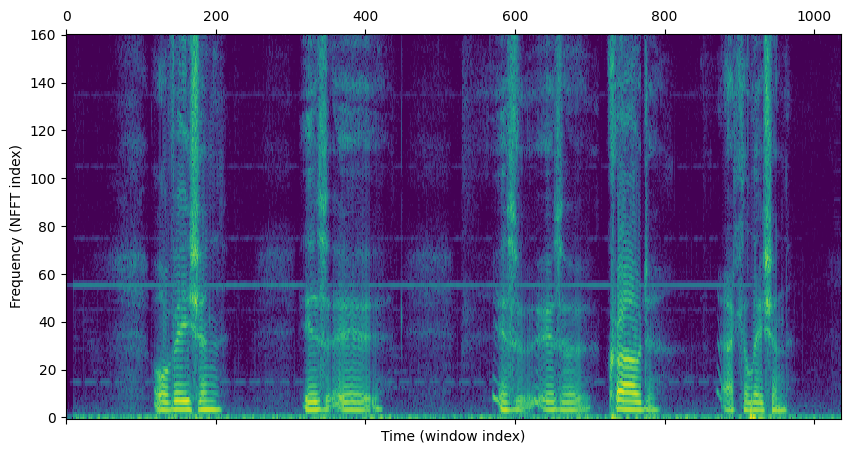

: 

In [ ]:
# display a single spectrogram
i = 5

f = plt.figure(figsize=(10, 5))
# convert spectrogram to decibel
log_spec = 10.0 * torch.log10(torch.maximum(spectrograms[i], torch.tensor(1e-10)))
log_spec = torch.maximum(log_spec, log_spec.max() - 80)

ax = f.gca()
ax.matshow(log_spec.T, origin="lower", aspect="auto")

# the time axis is dependent on the window hop used by the spectrogram
# this is usually 25ms for speech
plt.xlabel('Time (window index)')
# for this axis, the frequency domain goes from 0 : NFFT/2*fs
plt.ylabel('Frequency (NFFT index)')
plt.show()

We can then alternatively load in all the recordings.

**WARNING**: This takes a little under 15GB of memory!

In [11]:
audio_data = dataset.load_recordings()

Loading audio: 100%|██████████| 6360/6360 [00:26<00:00, 241.31it/s]


## Transcribe a single audio file

Now that we have loaded in the audio recordings, we can try to apply ML models. For example, we can transcribe the audio.

In [25]:
audio = resample_audios(audios=[audio_data[0]], resample_rate=16000)[0]

# display a widget to play the audio file
Ipd.display(Ipd.Audio(data=audio.waveform.squeeze(), rate=audio.sampling_rate))

# transcribe the audio file
model = HFModel(path_or_uri="openai/whisper-base")
transcription = transcribe_audios(audios=[audio_data[0]], model=model)[0]
print(transcription.text)

Whisper did not predict an ending timestamp, which can happen if audio is cut off in the middle of a word. Also make sure WhisperTimeStampLogitsProcessor was used during generation.


Sigh...
